In [27]:
import pandas as pd
from ENV import *
import gym
from gym import spaces
import numpy as np
import warnings
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

_x_sdbf, _x_npsdbf = None, None

from stable_baselines3 import PPO, DQN, A2C, DDPG, HER, TD3
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import CallbackList, CheckpointCallback, EvalCallback
import pickle, random
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.logger import TensorBoardOutputFormat

# Suppress FutureWarning and UserWarning
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

algorithm_name = 'dqn'
space_mode = 'discrete'

TEST = 'long'

if TEST == 'short':
  data_source = '../data/test.csv'
  TRAINING_DIVISOR = 2
elif TEST == 'long':
  data_source = '../data/test-long.csv'
  TRAINING_DIVISOR = 50
else:
  fn = 'btc22clean'
  data_source = f'../data/{fn}.csv'
  TRAINING_DIVISOR = 100
df = pd.read_csv(data_source)

In [28]:
class TradingEnvironment(gym.Env):
  # metadata = {'render.modes': ['human']}

  def __init__(self, df, algorithm_name, space_mode, evaluate=False):
    super().__init__()

    self.df = df
    df['return'] = 0
    df['mdd'] = 0
    
    self.algorithm_name = algorithm_name
    self.space_mode = space_mode # discrete or continuous

    # ACTION space
    if self.space_mode == 'discrete':
      # long, short, hold, close = 4
      self.action_space = spaces.Discrete(len(ACTIONS)) 
    else:
      # array[0] ACTIONS
      # array[1] AMOUNT - portion of portfolio, max is 1
      # array[2] LEVERAGE - later
      # array[3] SET_TP - later
      # array[4] SET_SL - later
      self.action_space = spaces.Box(low=np.array([0,0]), high=np.array([len(ACTIONS),1]), dtype=np.float16)

    # OBSERVATION space
    if self.space_mode == 'discrete':
      # arr[0] CLOSE - last close in value in log USDT
      # arr[1] VOLUME - in log
      # arr[2] DELTA - close / open in portion
      # arr[3] AMPLITUDE - high / low in portion
      # arr[4] CLOSE_OVER_LOW close / low in portion
      self.observation_space = spaces.Box(
        #                0   1   2   3   4
        low= np.array([-30,-30, -1,  0,  0] * LEN_FEATURES), 
        high=np.array([ 30, 30, 99, 99, 99] * LEN_FEATURES),
        shape=(WINDOW_SIZE * LEN_FEATURES,),
        dtype=np.float16
      )

    self.current_step = 0
    
    # Balances
    self.balance = INITIAL_ACCOUNT_BALANCE 
    self.net_worth = INITIAL_ACCOUNT_BALANCE
    self.max_net_worth = INITIAL_ACCOUNT_BALANCE 
    self.min_net_worth = INITIAL_ACCOUNT_BALANCE 
    self.mdd_base = INITIAL_ACCOUNT_BALANCE
    self.mdd = 0
    self.mdd_last_sell = 0 # MDD at last sell
    
    # Stats
    self.transactions_count = {'long': 0, 'short': 0}
    self.transaction_fees = {'long': 0, 'short': 0, 'close': 0}
    self.transaction_volume = {'long': 0, 'short': 0, 'close': 0}
    self.transaction_usd_volume = {'long': 0, 'short': 0, 'close': 0}
    self.portfolio = {'long': 0, 'short': 0}
    self.contract_price = {'long': 0, 'short': 0}

    # Rewards
    self.current_reward = 0
    self.total_reward = 0

    # Modes
    self.EVALUATE_MODE = evaluate

  def _next_observation(self):
    # Get data points for the last WINDOW_SIZE
    frame_start = self.current_step
    frame_end = frame_start + WINDOW_SIZE - 1
    frame = np.array([])
    for ft in FEATURES:
      _sliced_data = self.df.loc[frame_start:frame_end, ft]
      _sliced_data_log = _sliced_data
      if ft in ['close', 'volume']:
        _sliced_data_log = np.array([np.log(x) for x in np.nan_to_num(_sliced_data, nan=1)])
      frame = np.append(frame, _sliced_data_log)

    # obs = np.append(frame, [
    #   np.log(self.balance), 
    #   np.log(self.max_net_worth),
    # ], axis=0)
    obs = frame

    if len(obs) < WINDOW_SIZE * LEN_FEATURES:
      obs = np.pad(obs, (0, WINDOW_SIZE * LEN_FEATURES - len(obs)), mode='constant', constant_values=1)
    return obs
  
  def updatePortoValues(self):
    step = self.current_step
    current_price = self.df.loc[step, "close"]
    contract_value_long = self.portfolio['long'] * current_price
    contract_value_short = self.portfolio['short'] * current_price
    # print(self.balance, self.contract_price['short'], self.contract_price['long'], contract_value_long, contract_value_long, 'NW:', self.net_worth, '\n')
    self.net_worth = self.balance + contract_value_long + contract_value_short

    self.max_net_worth = max(self.max_net_worth, self.net_worth)
    if self.net_worth > self.max_net_worth:
      self.mdd_base = self.max_net_worth # set mdd base higher
    else:
      self.mdd_base = min(self.mdd_base, self.net_worth)

    self.min_net_worth = min(self.min_net_worth, self.net_worth)
    self.mdd = max(1 - self.net_worth/self.max_net_worth, self.mdd)
    self.df.loc[step, 'mdd'] = self.mdd
    self.df.loc[step, 'return'] = (self.net_worth - INITIAL_ACCOUNT_BALANCE) / INITIAL_ACCOUNT_BALANCE
  
  def getReturn(self):
    return self.net_worth / INITIAL_ACCOUNT_BALANCE - 1
  
  def handleTakeActionDiscrete(self, action):
    step = self.current_step
    current_price = self.df.loc[step, "close"]
    # Get action type: [0'long', 1'short', 2'hold', 3'close']
    action_type = action 

    try:
      self.df.loc[step - 1, 'position']
    except:
      action_type = 2

    # OPEN: LONG/SHORT: if has asset more than trx dollar
    if (action_type == 0 or action_type == 1):
      if self.balance >= MINIMUM_TRANSACTION_DOLLAR and self.portfolio['long'] == 0 and self.portfolio['short'] == 0:
        if action_type == 0:
          trx_type = 'long'
        else:
          trx_type = 'short'
        units_opened = round(self.balance / (current_price * (1 + TRADING_FEE_OPEN)), PRECISION)
        total_cost = units_opened * current_price
        fees = units_opened * TRADING_FEE_OPEN

        self.balance = self.balance - total_cost - fees
        self.transaction_volume[trx_type] += units_opened
        self.transaction_usd_volume[trx_type] += total_cost
        self.transaction_fees[trx_type] += fees
        self.transactions_count[trx_type] += 1
        self.df.loc[step, 'action'] = f'{trx_type} {units_opened:5f} @ {current_price}'

        # Update porto and return values
        # self.net_worth = self.balance + total_cost
        self.portfolio[trx_type] = units_opened
        if step > 0:
          self.df.loc[step, 'position'] = self.df.loc[step - 1, 'position'] + units_opened
        else: 
          self.df.loc[step, 'position'] = units_opened
        self.portfolio[trx_type] = self.df.loc[step, 'position']
        self.contract_price[trx_type] = current_price

        self.updatePortoValues()

        # Reward 
        self.current_reward = REWARD['open']
      else:
        action_type = 2
        # Reward: prevent long/shorting when no balance
        self.current_reward = REWARD['insufficient']

    # CLOSE
    if action_type == 3:
      if self.df.loc[step - 1, 'position'] * current_price >= MINIMUM_TRANSACTION_DOLLAR and step >= 0:
        trx_type = 'close'
        units_closed = self.portfolio['long'] + self.portfolio['short']
        fees = units_closed * TRADING_FEE_CLOSE
        
        profit = 0
        if self.portfolio['long'] > 0:
          profit = self.portfolio['long'] * (current_price - self.contract_price['long'])
        elif self.portfolio['short'] > 0:
          profit = self.portfolio['short'] * (-current_price + self.contract_price['short'])

        self.balance += units_closed * current_price - fees
        self.portfolio = {'long': 0, 'short': 0}
        try: 
          self.df.loc[step, 'position'] = self.df.loc[step - 1, 'position'] - units_closed
        except:
          self.df.loc[step, 'position'] = 0

        self.transaction_volume[trx_type] += units_closed
        self.transaction_usd_volume[trx_type] += units_closed * current_price
        self.transaction_fees[trx_type] += fees

        # Reward 
        self.current_reward = 100 * profit / self.net_worth
        self.df.loc[self.current_step, 'action'] = f'close {units_closed:5f} @ {current_price}'
        
        self.updatePortoValues()

      else:
        action_type = 2
        # Reward: prevent closing when no holding
        self.current_reward = REWARD['insufficient']

    # HOLD
    if action_type == 2:
      self.updatePortoValues()
      try: 
        self.df.loc[step, 'position'] = self.df.loc[step - 1, 'position']
      except:
        self.df.loc[step, 'position'] = 0
      self.df.loc[step, 'action'] = 'hold'

      # Reward 
      self.current_reward = REWARD['hold'] * self.getReturn()

    # print(action, action_type, self.df.loc[self.current_step, 'position'], self.df.loc[self.current_step, 'action'], self.balance)
    self.df.loc[self.current_step, 'reward'] = self.current_reward
    self.total_reward += self.current_reward

  def handleTakeActionContinuous(self, action):
    current_price = self.df.loc[self.current_step, "close"]
    if action == 0 and self.balance > np.log(MINIMUM_TRANSACTION_DOLLAR):
      pass
    # SHORT
    if action == 1 and self.balance > np.log(MINIMUM_TRANSACTION_DOLLAR):
      pass
    # HOLD
    if action == 2:
      pass
    # CLOSE
    if action == 3:
      pass

  def _take_action(self, action):
    if self.space_mode == 'discrete':
      self.handleTakeActionDiscrete(action)
    else: 
      self.handleTakeActionContinuous(action)
  
  def step(self, action):
    # end_ = len(self.df) - WINDOW_SIZE - 1
    end_ = len(self.df)

    self._take_action(action)
    self.current_step += 1
    obs = self._next_observation()
    if self.EVALUATE_MODE:
      done = self.current_step == end_
    else:
      done = self.current_step == int(end_ / TRAINING_DIVISOR)
    if (done):
      print(f'{self.current_step:6d}', 
            'RW ',  f'{self.total_reward:7.0f}', 
            'MD ',  f'{self.mdd:.3f}', 
            'RET ', f'{((self.net_worth - INITIAL_ACCOUNT_BALANCE) / INITIAL_ACCOUNT_BALANCE): 2.3f}',
            'FIN ', f'{INITIAL_ACCOUNT_BALANCE:7d} → {self.net_worth:7.0f}')
    return obs, self.current_reward, done, {}
  
  def reset(self):
    self.balance = INITIAL_ACCOUNT_BALANCE
    self.net_worth = INITIAL_ACCOUNT_BALANCE
    self.max_net_worth = INITIAL_ACCOUNT_BALANCE
    self.mdd_base = INITIAL_ACCOUNT_BALANCE
    self.min_net_worth = INITIAL_ACCOUNT_BALANCE
    self.mdd = 0
    self.mdd_last_sell = 0

    self.transactions_count = {'long': 0, 'short': 0}
    self.transaction_fees = {'long': 0, 'short': 0, 'close': 0}
    self.transaction_volume = {'long': 0, 'short': 0, 'close': 0}
    self.transaction_usd_volume = {'long': 0, 'short': 0, 'close': 0}
    self.portfolio = {'long': 0, 'short': 0}
    self.contract_price = {'long': 0, 'short': 0}

    self.total_reward = 0
    self.current_step = 0

    return self._next_observation()

  def render(self, mode='human', close=False):
    # Render the environment to the screen
    profit = self.net_worth - INITIAL_ACCOUNT_BALANCE

    print(f'Step: {self.current_step}')
    print(f'Balance: {self.balance}')
    print(f'Transaction Volume: {self.transaction_volume}')
    print(f'Transaction USD Volume: {self.transaction_usd_volume}')
    print(f'Transaction Fees: {self.transaction_fees}')
    print(f'Transaction Count: {self.transactions_count}')
    
    print(f'Net worth: {self.net_worth} (Max net worth: {self.max_net_worth}, min: {self.min_net_worth})')
    print(f'MDD: {self.mdd}')
    print(f'Profit: {profit}')
    print()

In [29]:
class SummaryWriterCallback(BaseCallback):
    def __init__(self):
      super().__init__()

    def _on_training_start(self):
      self._log_freq = int(len(df) / TRAINING_DIVISOR)  # log every INTERVAL calls

      output_formats = self.logger.output_formats
      # Save reference to tensorboard formatter object
      # note: the failure case (not formatter found) is not handled here, should be done with try/except.
      self.tb_formatter = next(formatter for formatter in output_formats if isinstance(formatter, TensorBoardOutputFormat))

    def _on_step(self) -> bool:
      # Log my_custom_reward every _log_freq(th) to tensorboard for each environment
      if self.n_calls % self._log_freq == self._log_freq - 1:
        _vars_locals_env = vars(self.locals['env'])
        _vars_locals_env = vars(_vars_locals_env['envs'][0])
        _vars_locals_env = vars(_vars_locals_env['gym_env'])
        total_reward = _vars_locals_env['total_reward']
        mdd = _vars_locals_env['mdd']
        return_ = _vars_locals_env['net_worth'] / INITIAL_ACCOUNT_BALANCE
        # print(total_reward, mdd, return_)
      # rewards = self.locals['my_custom_info_dict']['my_custom_reward']
      # for i in range(self.locals['env'].num_envs):
        self.tb_formatter.writer.add_scalar("rewards", total_reward, self.n_calls)
        self.tb_formatter.writer.add_scalar("mdd", mdd, self.n_calls)
        self.tb_formatter.writer.add_scalar("return_", return_, self.n_calls)
      return self.n_calls < len(df) * EPISODE

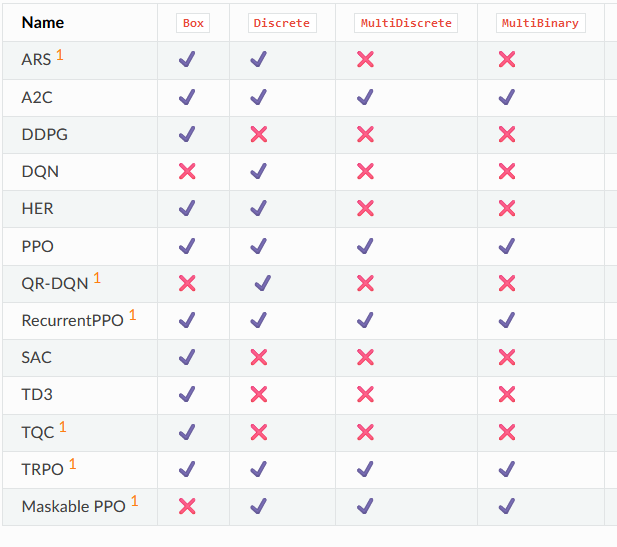

In [30]:
env = DummyVecEnv([lambda: TradingEnvironment(df, algorithm_name, space_mode)])
eval_callback = EvalCallback(env, 
                  best_model_save_path=f"./results/models_/{algorithm_name}_{space_mode}_best_model", 
                  log_path=f"./results/results_/{algorithm_name}_{space_mode}_res", 
                  eval_freq=len(df))
algorithm_name = algorithm_name
space_mode = space_mode
df = df

if algorithm_name == 'ppo':
  model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="./results/logs_", batch_size=128, device='cpu')
elif algorithm_name == 'dqn':
  model = DQN("MlpPolicy", env, verbose=1, tensorboard_log="./results/logs_", device='cpu')
elif algorithm_name == 'a2c':
  model = A2C("MlpPolicy", env, verbose=1, tensorboard_log="./results/logs_", device='cpu')
elif algorithm_name == 'ddpg':
  model = DDPG("MlpPolicy", env, verbose=1, tensorboard_log="./results/logs_", device='cpu')
elif algorithm_name == 'her':
  model = HER("MlpPolicy", env, verbose=1, tensorboard_log="./results/logs_", device='cpu')
elif algorithm_name == 'td3':
  model = TD3("MlpPolicy", env, verbose=1, tensorboard_log="./results/logs_", device='cpu')

def saveModel():
  # save best model
  model.save(f'./results/models_/model-{algorithm_name}-{space_mode}-{LEN_FEATURES}-{WINDOW_SIZE}-{random.randint(0,99)}')
  pickle.dump({'name': f'{algorithm_name}-{space_mode}', 'data': df}, open(f"'./results/models_/model-{algorithm_name}-{space_mode}-{LEN_FEATURES}-{WINDOW_SIZE}-{random.randint(0,99)}.pkl", 'ab'))

def plot(df=pd.DataFrame([]) ):
  if df.empty:
    dff = df.head(len(df) - WINDOW_SIZE - 1)
    fig = make_subplots(rows=2, cols=1, specs = [[{"secondary_y": False}], [{"secondary_y": False}]])
    fig.update_layout(autosize=False, width=1300, height=800, title_text=f'{algorithm_name}-{space_mode}')
    initial_price = float(df.head(1)['close'])
    fig.append_trace(go.Scatter( x=dff.index, y=dff['close'] / initial_price, name='Benchmark', legendgroup='1', marker=dict(size=42, color='black')), row=1, col=1)
    # Portfolio
    fig.append_trace(go.Scatter(x=dff.index,y=dff['return'] + 1,name='Portfolio', marker=dict(size=42,color='red',)), row=1, col=1)
    # MDD
    fig.add_trace(go.Scatter(x=dff.index,y=-dff['mdd'],name='MDD',marker=dict(size=42,color='blue',)), row=2, col=1)
    return fig
  

def evaluate(data_addr, label):
    dat_te = pd.read_csv(data_addr)
    dat_te = dat_te.reset_index(level=0)

    env_te = DummyVecEnv([lambda: TradingEnvironment(dat_te, algorithm_name, space_mode, True)])

    obs_te = env_te.reset()

    for i in range(len(dat_te)):
      action, _states = model.predict(obs_te)
      obs_te, rewards, done, info = env_te.step(action)
      if (i + 1) % 500 == 0 or i == len(dat_te) - 1:
        env_te.render()
    
    fig = plot(dat_te)

      # f'./results/evaluation_/{self.algorithm_name}-{self.space_mode}-{label}-test') 
      # custom_range=[min(dat_te['return']), 
      #               max(dat_te['return'])])

    # res_ = {
    #     'name': f'{self.algorithm_name}-{self.space_mode}-{label}-test',
    #     'data': dat_te,
    #     'figure': fig
    # }

    return fig

Using cpu device


In [31]:
checkpoint_callback = CheckpointCallback(save_freq=len(df), save_path=f"./results/logs_/{algorithm_name}_{space_mode}_log")
summary_cb = SummaryWriterCallback()
callback = CallbackList([checkpoint_callback, summary_cb])
model.learn(total_timesteps=EPISODE * len(df), log_interval=INTERVAL, callback=callback)


Logging to ./results/logs_\DQN_2
   403 RW      314 MD  0.002 RET  -0.001 FIN   100000 →   99867
   403 RW      341 MD  0.002 RET   0.003 FIN   100000 →  100313
   403 RW      295 MD  0.002 RET   0.000 FIN   100000 →  100002
   403 RW      339 MD  0.003 RET   0.000 FIN   100000 →  100000
   403 RW      365 MD  0.002 RET  -0.000 FIN   100000 →   99972
   403 RW      320 MD  0.001 RET   0.001 FIN   100000 →  100077
   403 RW      345 MD  0.002 RET   0.001 FIN   100000 →  100071
   403 RW      344 MD  0.003 RET   0.000 FIN   100000 →  100006
   403 RW      266 MD  0.003 RET   0.002 FIN   100000 →  100187
   403 RW      329 MD  0.003 RET  -0.002 FIN   100000 →   99840
   403 RW      375 MD  0.003 RET  -0.001 FIN   100000 →   99856
   403 RW      325 MD  0.002 RET   0.001 FIN   100000 →  100068
   403 RW      365 MD  0.001 RET   0.003 FIN   100000 →  100296
   403 RW      305 MD  0.002 RET   0.001 FIN   100000 →  100058
   403 RW      290 MD  0.003 RET  -0.001 FIN   100000 →   99944
   403 

In [32]:
# class SemiLiveAgent:
#   def __init__(self) -> None:
#     pass
# res = t.evaluate('../data/btc23clean.csv', 'btc23')
# res

In [33]:
# t.df